# MobileBert Approach 2

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Label Encoding ---
Number of unique topics: 20


--- Class Balancing ---
Resampled class distribution:
 label
15    14
3     14
14    14
11    14
12    14
4     14
0     14
9     14
18    14
7     14
2     14
19    14
6     14
17    14
16    14
8     14
1     14
13    14
5     14
10    14
Name: count, dtype: int64


--- Data Splitting ---
Training samples: 224
Validation samples: 56




Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting MobileBERT Model Training (Pre-processed Data) ---


Step,Training Loss
10,10369220.000000
20,1258712.300000
30,8031.856200
40,4.293300
50,3.472800
60,3.180700
70,3.038500
80,3.043600
90,2.865200
100,2.941400




--- Final Evaluation (Pre-processed Data) ---


Final Model Metrics: {'eval_loss': 2.5459134578704834, 'eval_accuracy': 0.26785714285714285, 'eval_precision': 0.3110119047619047, 'eval_recall': 0.26785714285714285, 'eval_f1': 0.2596165739022882, 'eval_runtime': 10.7804, 'eval_samples_per_second': 5.195, 'eval_steps_per_second': 0.649, 'epoch': 15.0}

Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.33      0.67      0.44         3
      cybersecur       1.00      0.33      0.50         3
            data       0.00      0.00      0.00         3
           digit       0.33      0.33      0.33         3
            educ       0.33      0.33      0.33         3
entrepreneurship       0.50      0.33      0.40         3
     environment       0.50      0.33      0.40         3
          health       1.00     

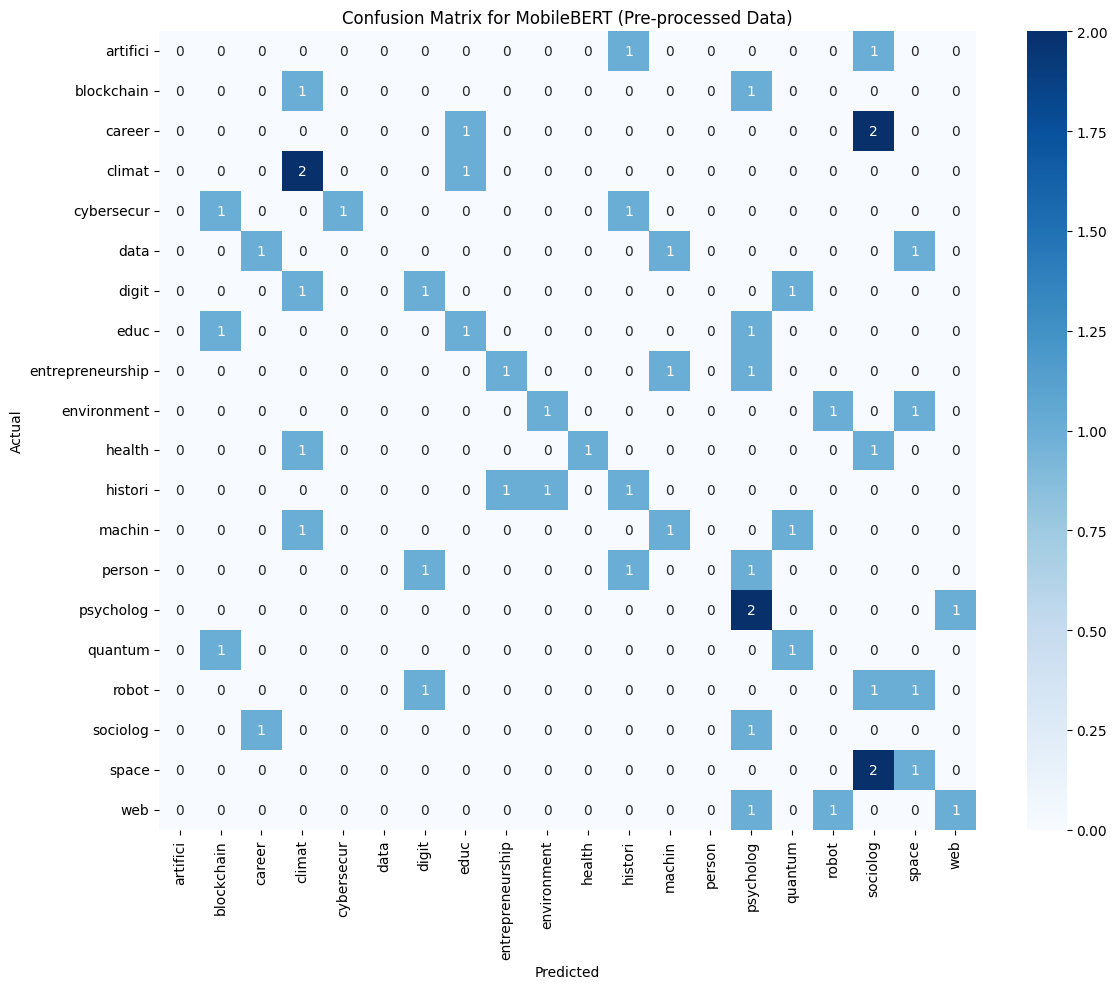

In [2]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv(r"E:\Sem 7 Project\Datasets\Preprocessed Datasets\output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

# Process question_text and all answer_item columns
text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

# Combine all processed text columns into a single 'text' column
df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()

# Process the topic column
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')

# Final cleanup
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']


print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")


# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

print("--- Label Encoding ---")
print(f"Number of unique topics: {num_labels}")
print("\n" + "="*50 + "\n")

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

print("--- Class Balancing ---")
print("Resampled class distribution:\n", df_balanced['label'].value_counts())
print("\n" + "="*50 + "\n")

# Step 6: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

print("--- Data Splitting ---")
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print("\n" + "="*50 + "\n")

# Step 7: Tokenization with MobileBertTokenizer
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
def tokenize(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Step 8: PyTorch Dataset Class
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset = TopicDataset(val_encodings, val_labels)

# Step 9: Define Model and Training Arguments
model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./mobilebert_results_preprocessed',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./mobilebert_logs_preprocessed',
    logging_steps=10,
    report_to=[],
)

# Step 10: Define Metrics Computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Step 11: Initialize and Train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("--- Starting MobileBERT Model Training (Pre-processed Data) ---")
trainer.train()
print("\n" + "="*50 + "\n")

# Step 12: Evaluate the Best Model
print("--- Final Evaluation (Pre-processed Data) ---")
metrics = trainer.evaluate()
print("Final Model Metrics:", metrics)

preds = trainer.predict(val_dataset)
y_true = val_labels.values
y_pred = preds.predictions.argmax(axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix for MobileBERT (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_preprocessed.png")
print("Confusion matrix saved as confusion_matrix_preprocessed.png")
print("\n" + "="*50 + "\n")

# Step 13: Inference on a New Example
print("--- Inference Example (Pre-processed Data) ---")
test_text = "marriag best film dream wish" # Example using pre-processed format
test_encodings = tokenize([test_text])

model.eval()
with torch.no_grad():
    device = trainer.args.device
    inputs = {k: v.to(device) for k, v in test_encodings.items()}
    
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

# Electra Bert

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Data Loading (Pre-processed Data) ---
Data shape: (200, 2)




Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting ELECTRA Model Training (Pre-processed Data) ---


Step,Training Loss
10,3.000500
20,3.023900
30,3.008900
40,2.995300
50,3.005300
60,2.991500
70,2.962400
80,2.974400
90,2.972900
100,2.937000




--- Final Evaluation (Pre-processed Data) ---


Final Model Metrics: {'eval_loss': 2.7235641479492188, 'eval_accuracy': 0.26785714285714285, 'eval_precision': 0.16040120593692023, 'eval_recall': 0.26785714285714285, 'eval_f1': 0.18742913832199545, 'eval_runtime': 31.2184, 'eval_samples_per_second': 1.794, 'eval_steps_per_second': 0.224, 'epoch': 12.0}

Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.00      0.00      0.00         3
      cybersecur       0.00      0.00      0.00         3
            data       0.00      0.00      0.00         3
           digit       0.00      0.00      0.00         3
            educ       0.00      0.00      0.00         3
entrepreneurship       0.25      0.33      0.29         3
     environment       0.67      0.67      0.67         3
          health       0.67   

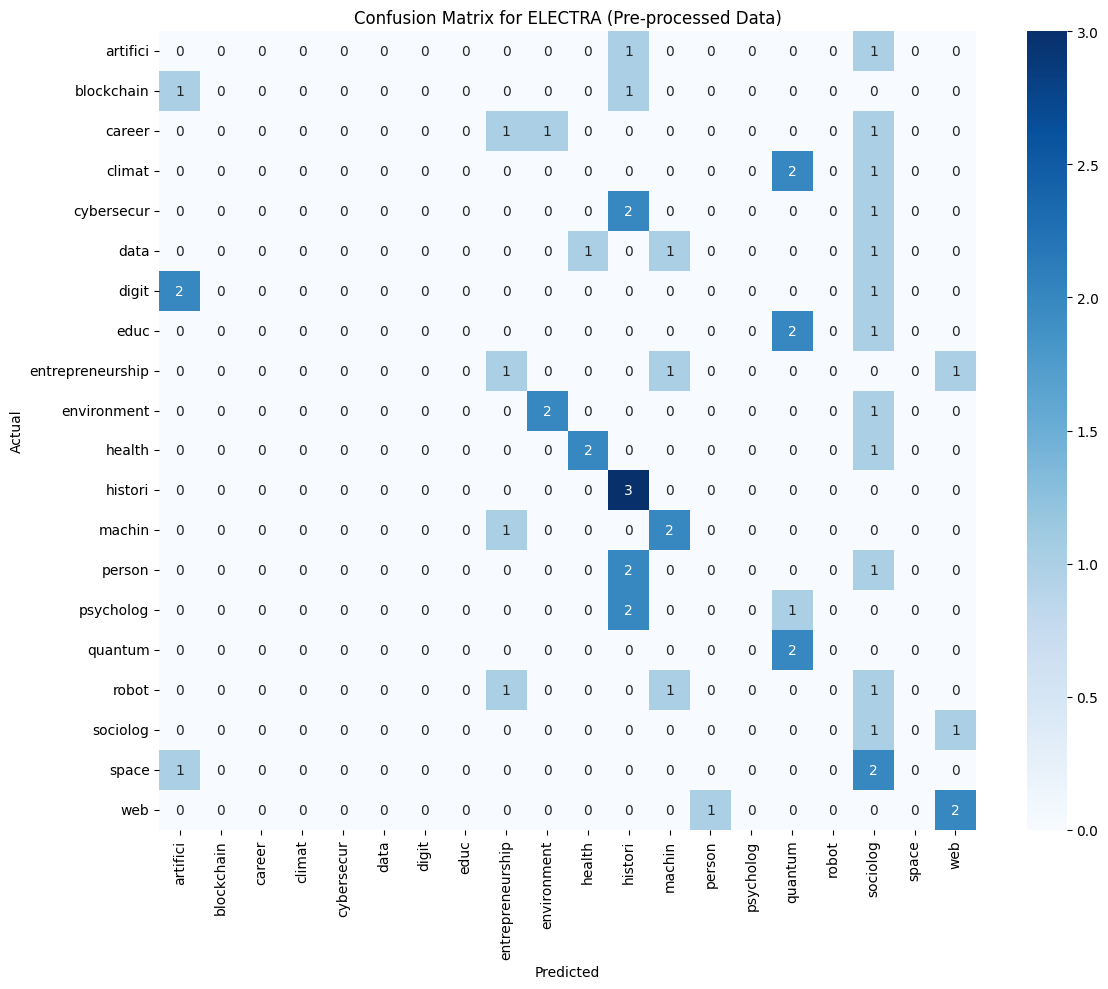

In [1]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv(r"E:\Sem 7 Project\Datasets\Preprocessed Datasets\output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

# Process question_text and all answer_item columns
text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

# Combine all processed text columns into a single 'text' column
df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading (Pre-processed Data) ---")
print("Data shape:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

# Step 6: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Tokenization with ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
def tokenize(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Step 8: PyTorch Dataset Class
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset = TopicDataset(val_encodings, val_labels)

# Step 9: Define Model and Training Arguments
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./electra_results_preprocessed',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./electra_logs_preprocessed',
    logging_steps=10,
    report_to=[],
)

# Step 10: Define Metrics Computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Step 11: Initialize and Train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("--- Starting ELECTRA Model Training (Pre-processed Data) ---")
trainer.train()
print("\n" + "="*50 + "\n")

# Step 12: Evaluate and Report
print("--- Final Evaluation (Pre-processed Data) ---")
metrics = trainer.evaluate()
print("Final Model Metrics:", metrics)
preds = trainer.predict(val_dataset)
y_true = val_labels.values
y_pred = preds.predictions.argmax(axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix for ELECTRA (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_electra_preprocessed.png")
print("Confusion matrix saved as confusion_matrix_electra_preprocessed.png")
print("\n" + "="*50 + "\n")

# Step 13: Inference
print("--- Inference Example (Pre-processed Data) ---")
test_text = "marriag best film dream wish"
test_encodings = tokenize([test_text])
model.eval()
with torch.no_grad():
    device = trainer.args.device
    inputs = {k: v.to(device) for k, v in test_encodings.items()}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")